# Explore here

### Paso 1: Planteamiento del problema y recopilación de datos


**Prediciendo la diabetes**

Este conjunto de datos proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo es predecir en base a medidas diagnósticas si un paciente tiene o no diabetes.


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [486]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import json
from numpy._core.defchararray import upper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [487]:
url = "https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv"
total_data = pd.read_csv(url)
total_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Paso 2: Exploración y limpieza de datos
Hay que conocer las dimensiones y tipologías de datos del objeto con el que estamos trabajando es vital. Para ello necesitamos el atributo shape para obtener las dimensiones del objeto y la función info() para conocer la tipología y la cantidad de valores no nulos:

In [488]:
#Conocer las dimensiones
total_data.shape
print(f"Hay {total_data.shape[0]} filas y {total_data.shape[1]} columnas")

Hay 768 filas y 9 columnas


In [489]:
# Obtener información sobre tipos de datos y valores no nulos
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [490]:
vars_numericas = total_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
vars_categoricas = total_data.select_dtypes(include=["object"]).columns.tolist()
print(vars_categoricas,vars_numericas)

[] ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


No hay variables categóricas


**Eliminación de duplicados**

In [491]:
num_duplicates = total_data.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

if num_duplicates > 0:
    total_data = total_data.drop_duplicates().reset_index(drop = True)
    print(f"Número duplicados borrados. Ahora hay {total_data.shape[0]} datos")
else:
    print("No se han encontrado duplicados")

Número de filas duplicadas: 0
No se han encontrado duplicados


### Paso 3: Análisis de variables univariante
Una variable univariante es un término estadístico que se emplea para referenciar un conjunto de observaciones de un atributo. Esto es, el análisis columna a columna del DataFrame. Para ello, debemos distinguir si una variable es categórica o numérica, ya que el cuerpo del análisis y las conclusiones que se pueden obtener serán distintas.

**Análisis sobre variables numéricas**:

Una variable numérica es un tipo de variable que puede tomar valores numéricos (enteros, fracciones, decimales, negativos, etc.) en un rango infinito. Una variable categórica numérica puede ser también una variable numérica (por ejemplo, para los sucesivos análisis, podemos tomar la clase Survived como numérica también para estudiar relaciones). Normalmente se representan utilizando un histograma y diagramas de caja, expuestos juntos.

Las variables numéricas son ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


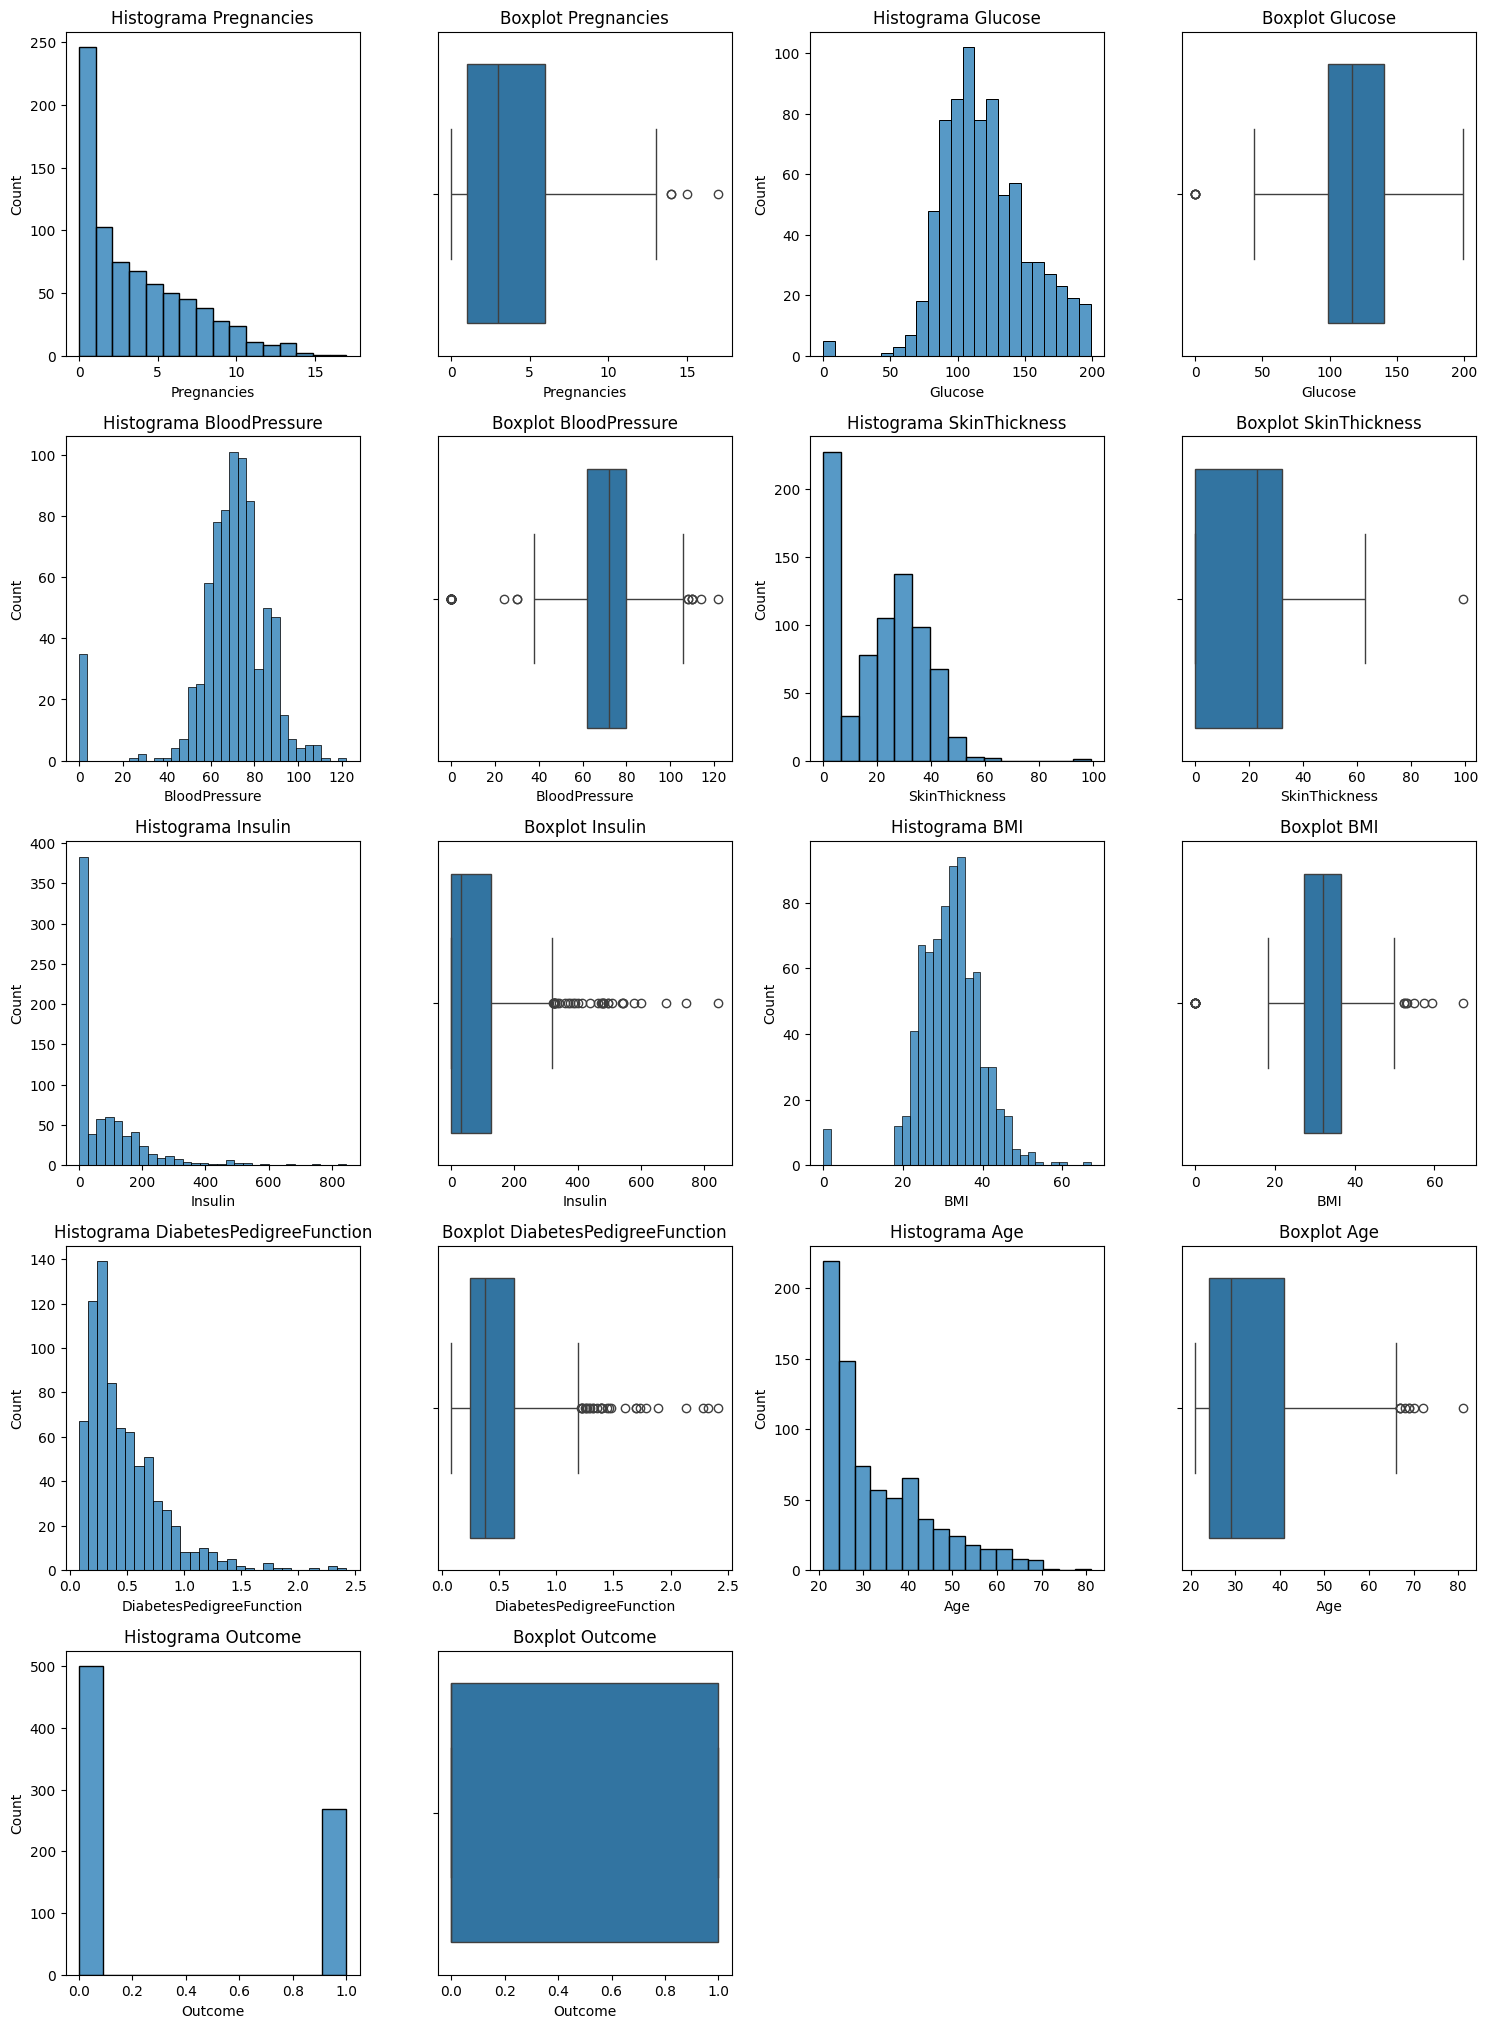

In [492]:
print(f"Las variables numéricas son {vars_numericas}")

n_cols = 4
n_rows = 2*(math.ceil(len(vars_numericas) / n_cols))

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()

for i, col in enumerate(vars_numericas):
    sns.histplot(data=total_data, x=col, ax=axis[2*i])
    axis[2*i].set_title(f"Histograma {col}")

    sns.boxplot(data=total_data, x=col, ax=axis[2*i + 1])
    axis[2*i + 1].set_title(f"Boxplot {col}")

# Eliminar subplots sobrantes
for j in range(2*i + 2, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

### Paso 4: Análisis de variables multivariante

Tras analizar las características una a una, es momento de analizarlas en relación con la predictora y con ellas mismas, para sacar conclusiones más claras acerca de sus relaciones y poder tomar decisiones sobre su procesamiento.

Así, si quisiéramos eliminar una variable debido a una alta cantidad de valores nulos o ciertos outliers, es necesario antes aplicar este proceso para asegurar que la eliminación de ciertos valores no son críticos

**Análisis numérico-numérico:**

Cuando las dos variables que se comparan tienen datos numéricos, se dice que el análisis es numérico-numérico. Para comparar dos columnas numéricas se utilizan diagramas de dispersión y análisis de correlaciones.

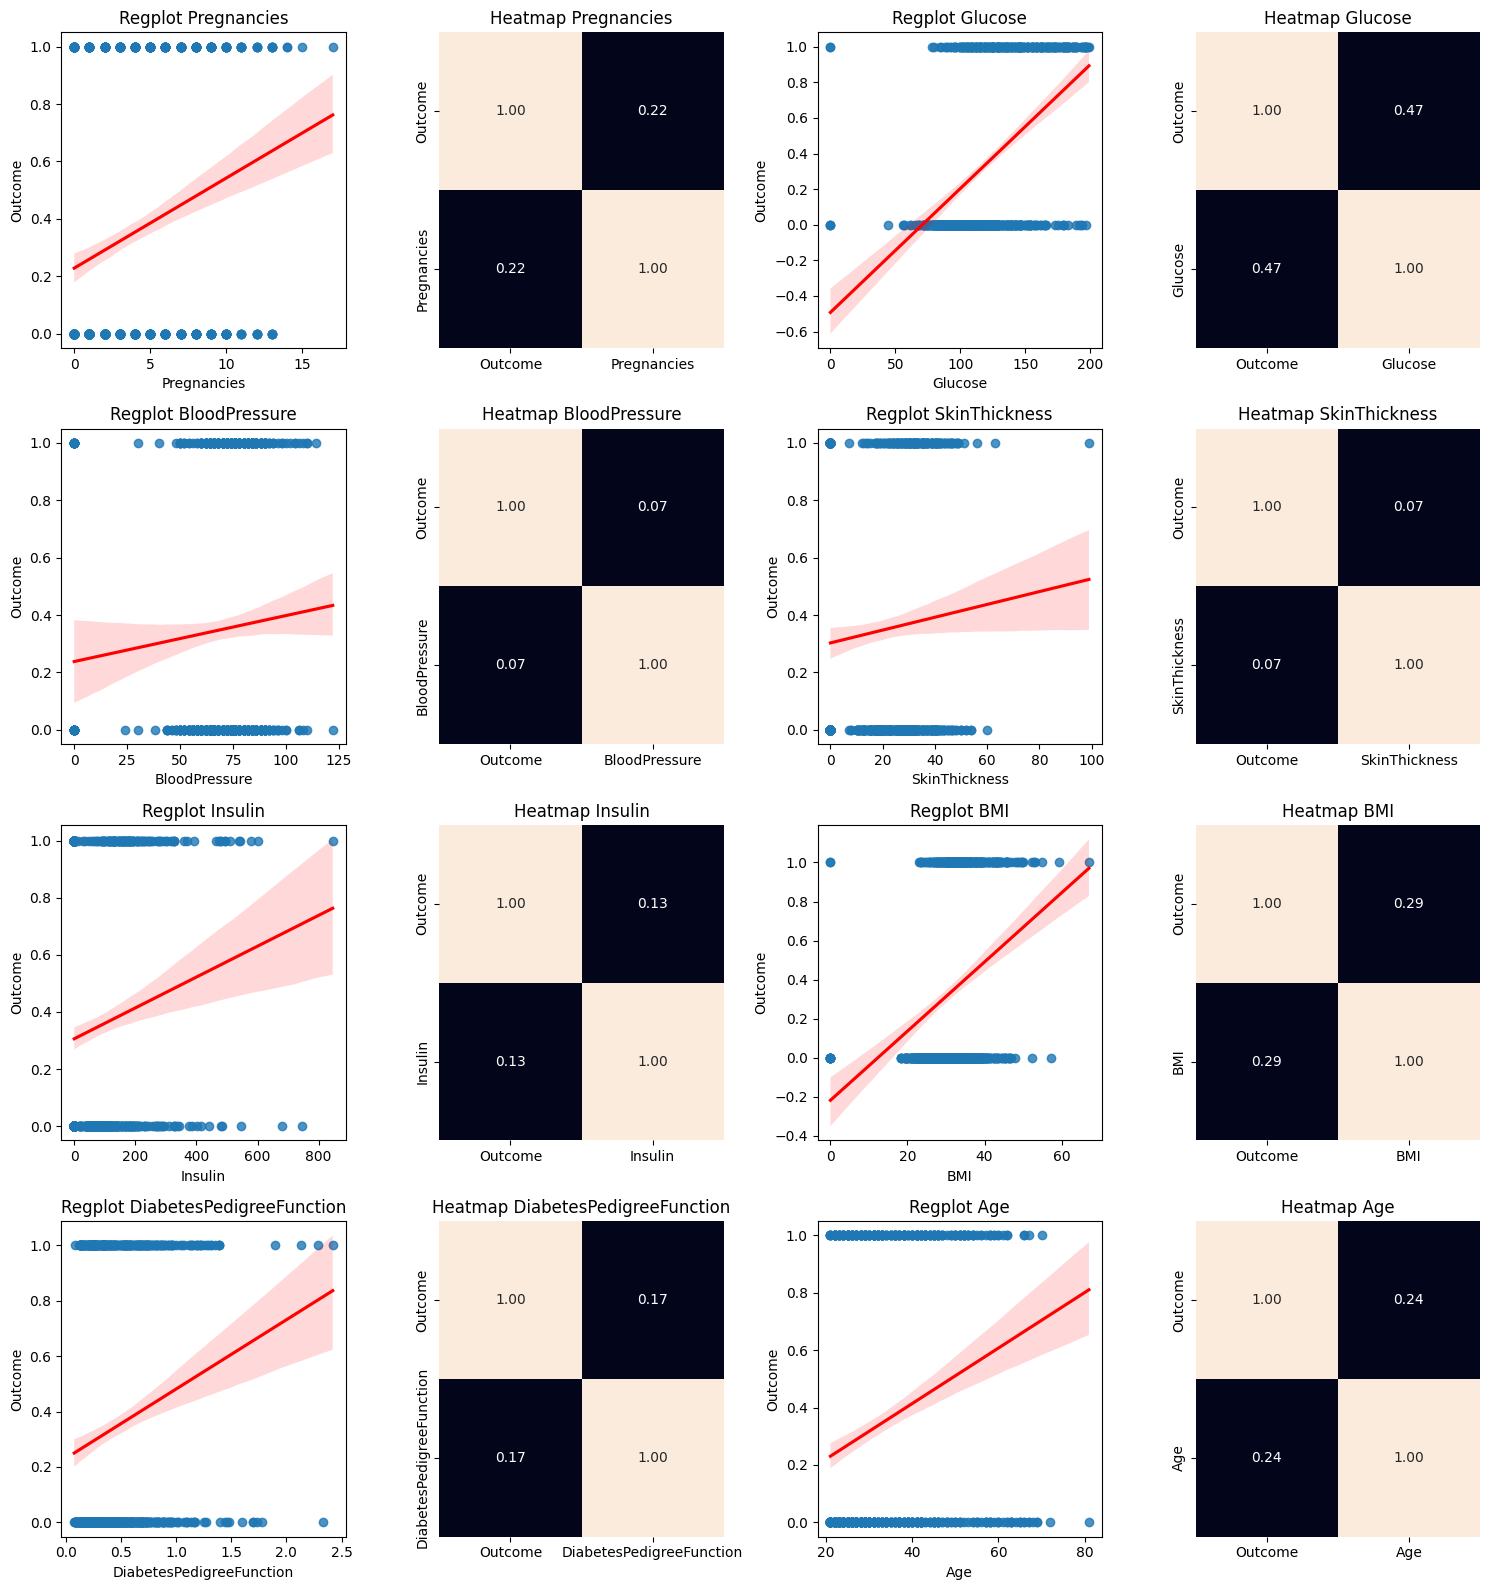

In [493]:
n_cols = 4
target="Outcome"
vars_num_sin_pred=[col for col in vars_numericas if col != target]
n_rows =2*( math.ceil(len(vars_num_sin_pred) / n_cols))

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()
for i, col in enumerate(vars_num_sin_pred):
    sns.regplot(ax = axis[2*i], data = total_data, x = col, y = target,line_kws={"color": "red"})
    axis[2*i].set_title(f"Regplot {col}")
    sns.heatmap(total_data[[target,col]].corr(), annot = True, fmt = ".2f", ax = axis[2*i + 1], cbar = False)
    axis[2*i + 1].set_title(f"Heatmap {col}")

# Eliminar subplots sobrantes
for j in range(2*i + 2, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()


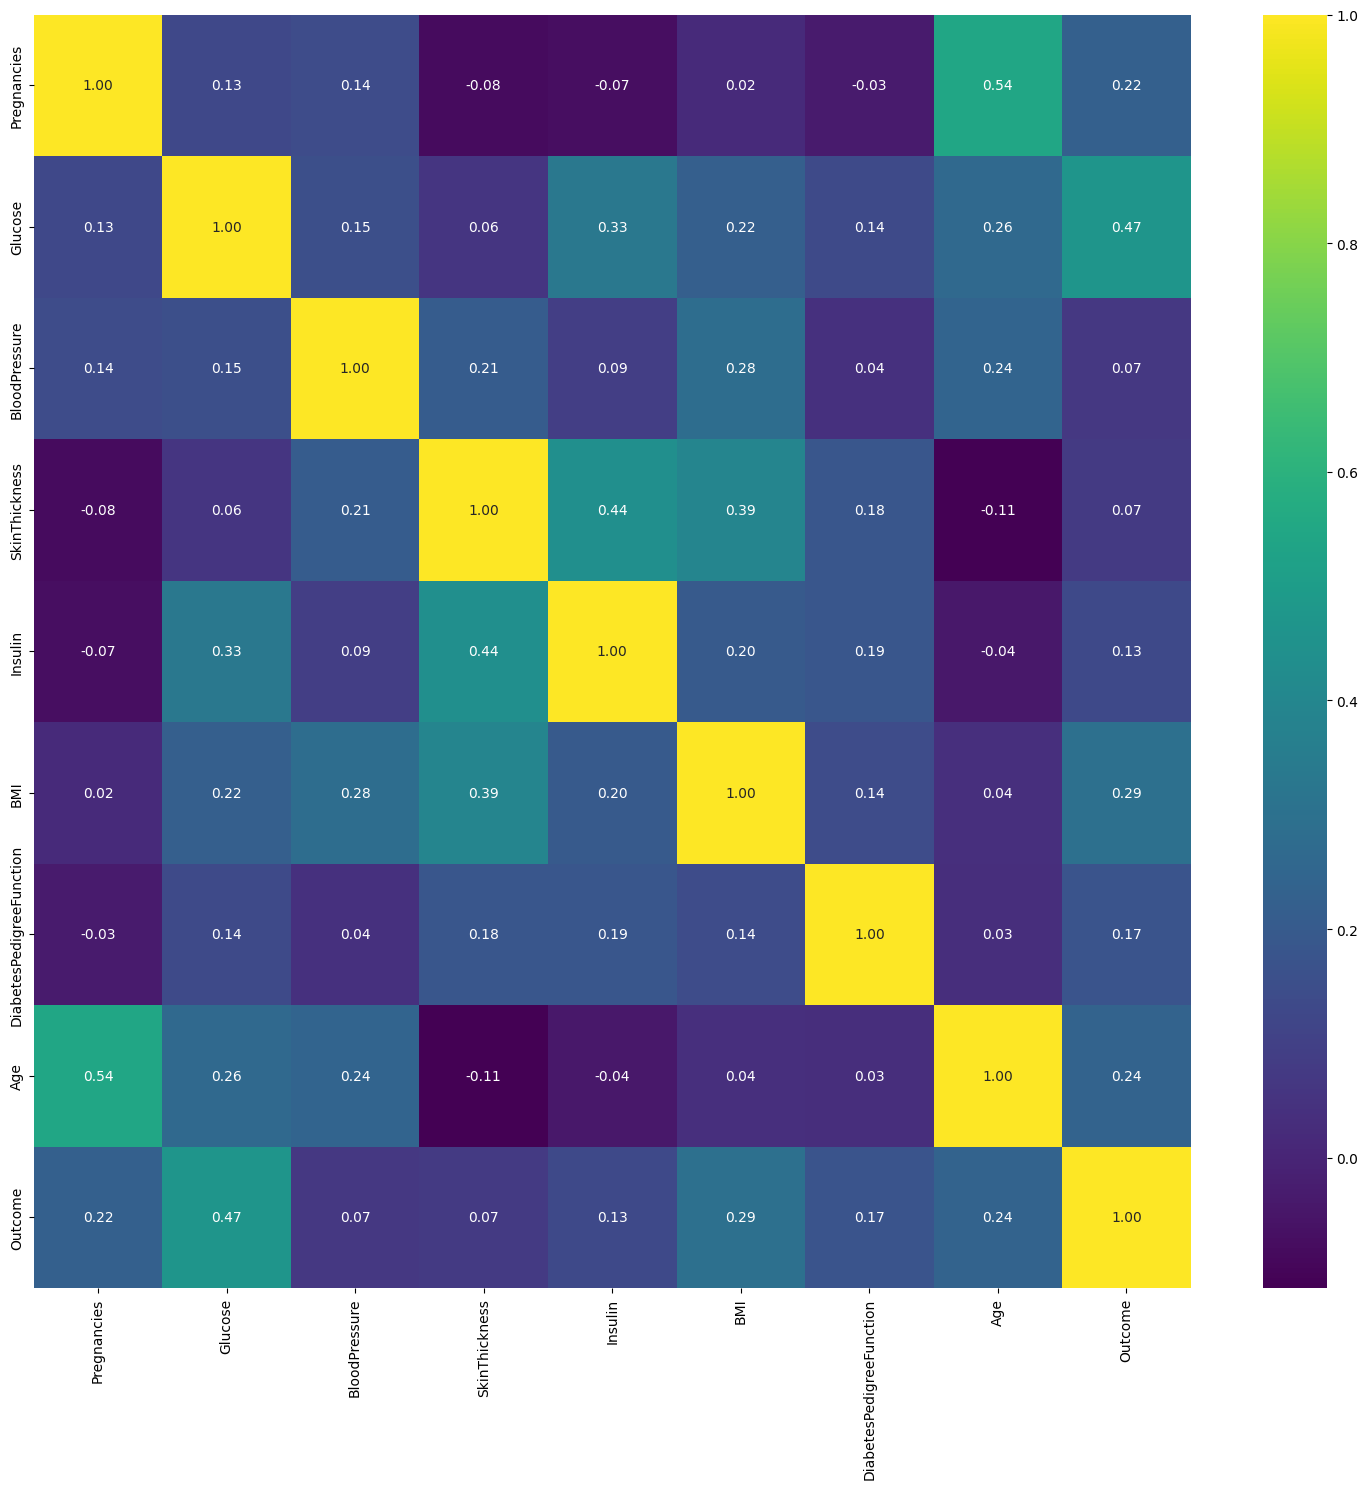

In [494]:
vars_final=vars_categoricas+vars_numericas
total_data=total_data[vars_final]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(total_data[vars_final].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()

Las mas correlacionadas son la glucosa, el BMI y la cantidad de embarazos. Las otras variables tienen correlaciones menores a 0.20

## Paso 5: Ingeniería de características

La ingeniería de características (*feature engineering*) es un proceso que implica la creación de nuevas características (o variables) a partir de las existentes para mejorar el rendimiento del modelo. Esto puede implicar una variedad de técnicas como la normalización, la transformación de los datos, etcétera. El objetivo es mejorar la precisión del modelo y/o reducir la complejidad del mismo, facilitando así su interpretación.

En los pasos previos hemos empezado a trabajar con los datos eliminando duplicados, contabilizando los valores nulos e, incluso, para calcular correlaciones. Si bien esto podríamos haberlo hecho en este paso, ya que forma parte de la ingeniería de características, normalmente suele hacerse antes de analizar las variables, separando este proceso en uno previo y este que vamos a ver a continuación.

**Análisis de outliers**

Un valor atípico (*outlier*) es un punto de datos que se desvía significativamente de los demás. Es un valor que es notablemente diferente de lo que sería de esperar dada la tendencia general de los datos. Estos outliers pueden ser causados por errores en la recolección de datos, variaciones naturales en los datos, o pueden ser indicativos de algo significativo, como una anomalía o evento extraordinario.

El análisis descriptivo es una poderosa herramienta para caracterizar el conjunto de datos: la media, desviación y los cuartiles nos brindan una poderosa información sobre cada variable. La función `describe()` de un DataFrame nos ayuda a calcular en unos tiempos muy reducidos todos estos valores.

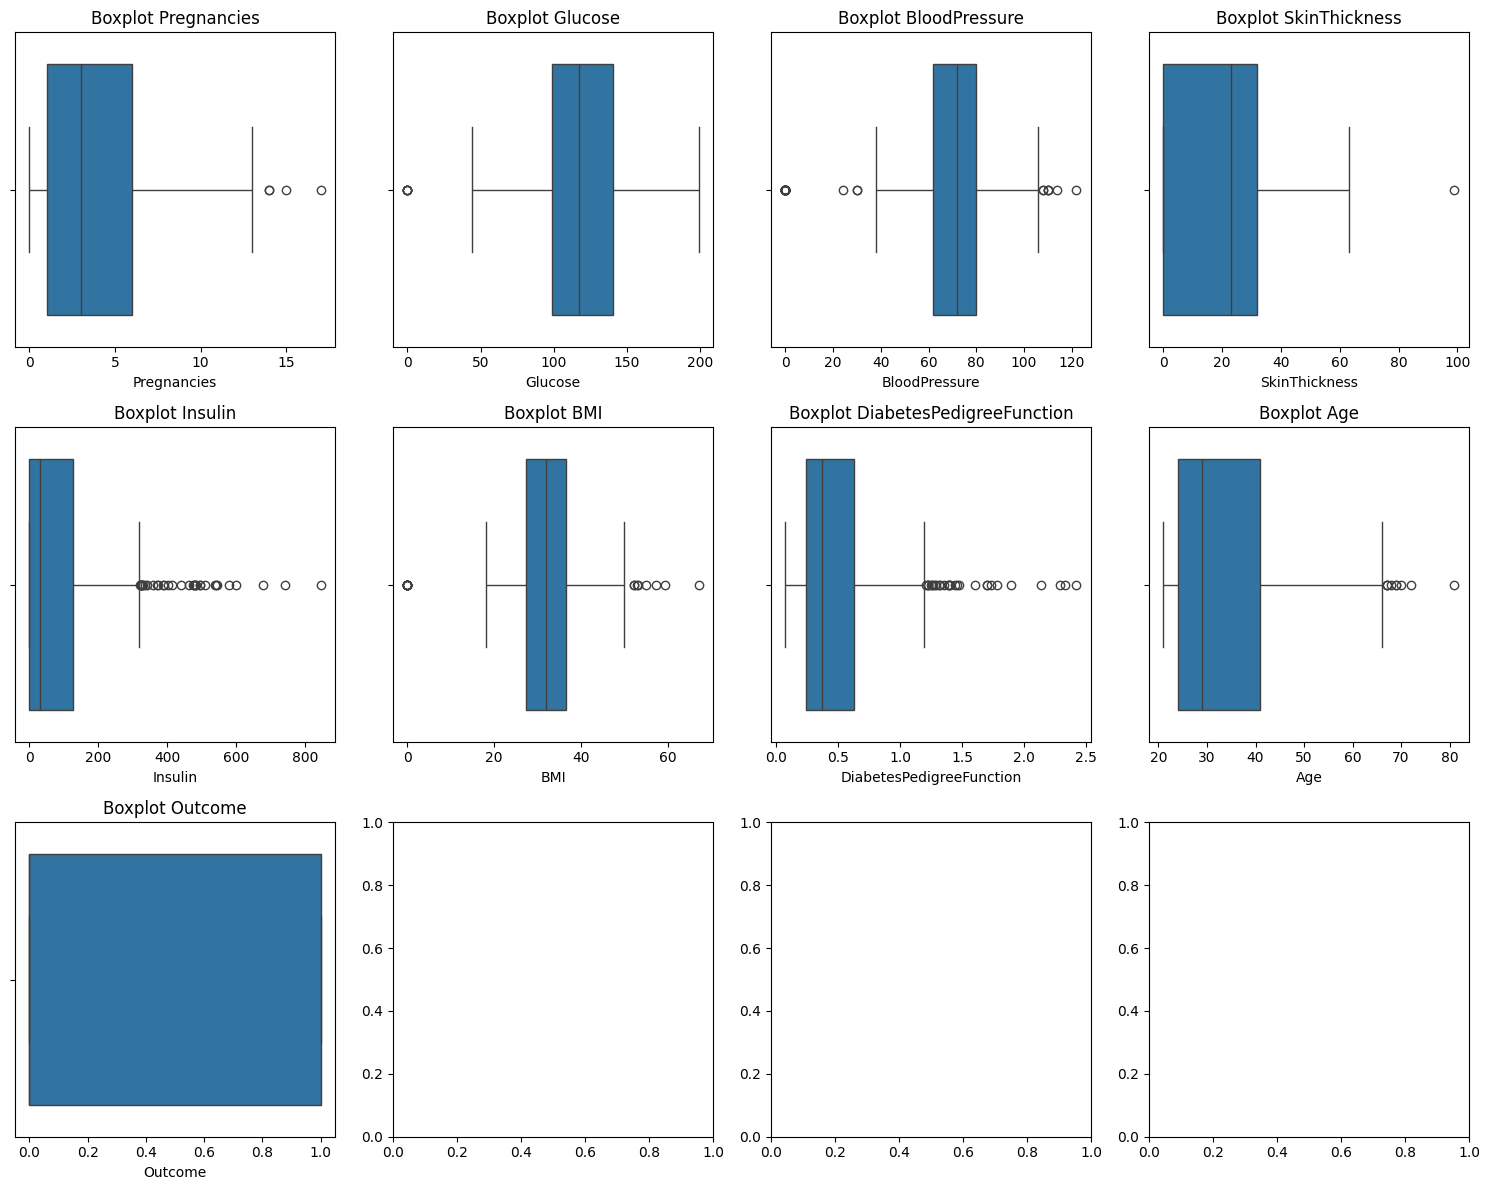

In [495]:
n_cols = 4
n_rows = math.ceil(len(vars_final) / n_cols)

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()

for i, col in enumerate(vars_final):
    sns.boxplot(data=total_data, x=col, ax=axis[i])
    axis[i].set_title(f"Boxplot {col}")

plt.tight_layout()
plt.show()


In [496]:
total_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Todas las variables sufren de datos atipicos

In [497]:

predictoras=[col for col in vars_final if col != target]
total_data_CON_outliers = total_data.copy()
total_data_SIN_outliers = total_data.copy() # Lo vamos a modificar. Para cada variable con outliers, reemplazamos sus valores outliers

outliers_cols = predictoras

def replace_outliers(column, df):
  col_stats = total_data[column].describe()
  col_iqr = col_stats["75%"] - col_stats["25%"]
  upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
  lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

  if lower_limit < 0: lower_limit = min(df[column])
  # Vamos a quitar los outliers superiores
  df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Vamos a quitar los outliers inferiores
  df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
  total_data_SIN_outliers, limits = replace_outliers(column, total_data_SIN_outliers)
  outliers_dict.update({column: limits})

outliers_dict # Este JSON me lo tengo que GUARDAR
with open("./outliers_dict.json", "w") as f:
  json.dump(outliers_dict, f)

**Análisis de valores faltantes**

Un *valor faltante* (*missing value*) es un espacio que no tiene valor asignado en la observación de una variable específica. Este tipo de valores son bastante comunes y pueden surgir por muchas razones. Por ejemplo, podría haber un error en la recopilación de datos, alguien podría haberse negado a responder una pregunta en una encuesta, o simplemente podría ser que cierta información no esté disponible o no sea aplicable.

La función `isnull()` es una poderosa herramienta para obtener esta información:


In [498]:
total_data_CON_outliers.isnull().sum().sort_values(ascending=False)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

No hay nulos en ninguna de los data sets

## Paso 5.5: Aplicación

El *escalado de valores* (*feature scaling*) es un paso crucial en el preprocesamiento de datos para muchos algoritmos de Machine Learning. Es una técnica que cambia el rango de los valores de los datos para que puedan ser comparables entre sí. El escalado normalmente implica la normalización, que es el proceso de cambiar los valores para que tengan una media de 0 y una desviación estándar de 1. Otra técnica común es el escalado mínimo-máximo, que transforma los datos para que todos los valores estén entre 0 y 1.

Antes de escalar los valores, debemos asegurarnos de que todas nuestras variables predictoras sean numéricas. Una vez preparadas, podemos aplicar técnicas como la normalización o el escalado Min-Max directamente sobre el dataset completo. Más adelante, cuando pasemos a la fase de modelado, será el momento de dividir los datos en entrenamiento y prueba.


In [499]:
# total_data_SIN_outliers
# total_data_CON_outliers
X_CON = total_data_CON_outliers.drop(target, axis = 1)[predictoras]
X_SIN = total_data_SIN_outliers.drop(target, axis = 1)[predictoras]
y = total_data_CON_outliers[target]

X_train_CON_outliers, X_test_CON_outliers, y_train, y_test = train_test_split(X_CON, y, test_size = 0.2, random_state = 10)
X_train_SIN_outliers, X_test_SIN_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 10)

In [500]:
# X_train_CON_outliers
# X_train_SIN_outliers

# X_test_CON_outliers
# X_test_SIN_outliers

# TENGO QUE GUARDARME TRES SITUACIONES: 1) DATASET SIN TOCAR, 2) DATASET NORMALIZADO, 3) DATASET MIN-MAX

## NORMALIZACIÓN
### CON OUTLIERS
norm_CON_outliers = StandardScaler()
norm_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_norm = norm_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_norm = pd.DataFrame(X_train_CON_outliers_norm, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_norm = norm_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_norm = pd.DataFrame(X_test_CON_outliers_norm, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
norm_SIN_outliers = StandardScaler()
norm_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_norm = norm_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_norm = pd.DataFrame(X_train_SIN_outliers_norm, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_norm = norm_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_norm = pd.DataFrame(X_test_SIN_outliers_norm, index = X_test_SIN_outliers.index, columns = predictoras)


## ESCALADO MIN-MAX (MINMAXIMIZACIÓN)
### CON OUTLIERS
scaler_CON_outliers = MinMaxScaler()
scaler_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_scal = scaler_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_scal = pd.DataFrame(X_train_CON_outliers_scal, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_scal = scaler_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_scal = pd.DataFrame(X_test_CON_outliers_scal, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
scaler_SIN_outliers = MinMaxScaler()
scaler_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_scal = scaler_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_scal = pd.DataFrame(X_train_SIN_outliers_scal, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_scal = scaler_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_scal = pd.DataFrame(X_test_SIN_outliers_scal, index = X_test_SIN_outliers.index, columns = predictoras)

# X_train_CON_outliers
# X_train_CON_outliers_norm
# X_train_CON_outliers_scal
# X_train_SIN_outliers
# X_train_SIN_outliers_norm
# X_train_SIN_outliers_scal

# X_test_CON_outliers
# X_test_CON_outliers_norm
# X_test_CON_outliers_scal
# X_test_SIN_outliers
# X_test_SIN_outliers_norm
# X_test_SIN_outliers_scal

In [501]:
# DATASETS QUE HE IDO ACUMULANDO EN LOS PASOS 4 Y 5
X_train_CON_outliers.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers.xlsx", index = False)
X_train_CON_outliers_norm.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers_norm.xlsx", index = False)
X_train_CON_outliers_scal.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers_scal.xlsx", index = False)
X_train_SIN_outliers.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers.xlsx", index = False)
X_train_SIN_outliers_norm.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers_norm.xlsx", index = False)
X_train_SIN_outliers_scal.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers_scal.xlsx", index = False)

X_test_CON_outliers.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers.xlsx", index = False)
X_test_CON_outliers_norm.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers_norm.xlsx", index = False)
X_test_CON_outliers_scal.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers_scal.xlsx", index = False)
X_test_SIN_outliers.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers.xlsx", index = False)
X_test_SIN_outliers_norm.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers_norm.xlsx", index = False)
X_test_SIN_outliers_scal.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers_scal.xlsx", index = False)

y_train.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/y_train.xlsx", index = False)
y_test.to_excel("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/y_test.xlsx", index = False)

# SCALERS


with open("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/models/norm_CON_outliers.pkl", "wb") as file:
  pickle.dump(norm_CON_outliers, file)
with open("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/models/norm_SIN_outliers.pkl", "wb") as file:
  pickle.dump(norm_SIN_outliers, file)
with open("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/models/scaler_CON_outliers.pkl", "wb") as file:
  pickle.dump(scaler_CON_outliers, file)
with open("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/models/scaler_SIN_outliers.pkl", "wb") as file:
  pickle.dump(scaler_SIN_outliers, file)

### Paso 6: Selección de características

La **selección de características** (*feature selection*) es un proceso que implica seleccionar las características (variables) más relevantes de nuestro conjunto de datos para usarlas en la construcción de un modelo de Machine Learning, desechando el resto.

Existen varias razones para incluirlo en nuestro análisis exploratorio:

1. Simplificar el modelo para que sea más fácil de entender e interpretar.
2. Reducir el tiempo de entrenamiento del modelo.
3. Evitar el sobre ajuste al reducir la dimensionalidad del modelo y minimizar el ruido y las correlaciones innecesarias.
4. Mejorar el rendimiento del modelo al eliminar las características irrelevantes.

In [502]:
datasets = [
    X_train_CON_outliers,
    X_train_CON_outliers_norm,
    X_train_CON_outliers_scal,
    X_train_SIN_outliers,
    X_train_SIN_outliers_norm,
    X_train_SIN_outliers_scal
]
dataset_names = [
    "X_train_CON_outliers",
    "X_train_CON_outliers_norm",
    "X_train_CON_outliers_scal",
    "X_train_SIN_outliers",
    "X_train_SIN_outliers_norm",
    "X_train_SIN_outliers_scal"]

models = []
accs = []
for i,dataset in enumerate(datasets):
  model = LogisticRegression(random_state=10) # Regresión Logística
  model.fit(dataset, y_train) # Entreno el modelo
  y_pred = model.predict(dataset)
  acc = accuracy_score(y_train, y_pred)
  accs.append(acc)
  models.append(model)
  print(f"Accuracy del dataset {i}: {acc:.4f}")

best_acc = max(accs)
best_index = accs.index(best_acc)
print(f"\nEl mejor dataset es el dataset {best_index}, es decir, {dataset_names[best_index]} con accuracy = {best_acc:.4f}")


Accuracy del dataset 0: 0.7720
Accuracy del dataset 1: 0.7736
Accuracy del dataset 2: 0.7785
Accuracy del dataset 3: 0.7769
Accuracy del dataset 4: 0.7752
Accuracy del dataset 5: 0.7720

El mejor dataset es el dataset 2, es decir, X_train_CON_outliers_scal con accuracy = 0.7785


In [503]:
X_train = X_train_CON_outliers_scal.copy()
X_test = X_test_CON_outliers_scal.copy()

selection_model = SelectKBest(f_classif,k = 5)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel_CON_outliers = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel_CON_outliers = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])
X_train_sel_CON_outliers[target] = list(y_train)
X_test_sel_CON_outliers[target] = list(y_test)
X_train_sel_CON_outliers.to_csv("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_train_sel_CON_outliers_clean.csv", index = False)
X_test_sel_CON_outliers.to_csv("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_test_sel_CON_outliers_clean.csv", index = False)

In [504]:
X_train = X_train_CON_outliers_scal.copy()
X_test = X_test_CON_outliers_scal.copy()


selection_model = SelectKBest(f_classif, k = 5)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel_CON_outliers_scal = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel_CON_outliers_scal = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])
X_train_sel_CON_outliers_scal[target] = list(y_train)
X_test_sel_CON_outliers_scal[target] = list(y_test)
X_train_sel_CON_outliers_scal.to_csv("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_train_sel_CON_outliers_scal_clean.csv", index = False)
X_test_sel_CON_outliers_scal.to_csv("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/data/processed/X_test_sel_CON_outliers_scal_clean.csv", index = False)

## Decision Tree model

In [505]:
train_data = X_train_sel_CON_outliers_scal
test_data = X_test_sel_CON_outliers_scal
train_data.head()

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.000000,0.814070,0.792846,0.290777,0.066667,1
1,0.117647,0.437186,0.430700,0.296755,0.066667,0
2,0.000000,0.688442,0.369598,0.027754,0.000000,0
3,0.588235,0.577889,0.526080,0.023911,0.133333,0
4,0.000000,0.522613,0.500745,0.184458,0.016667,1


**Paso 1. Lectura del conjunto de datos procesado**

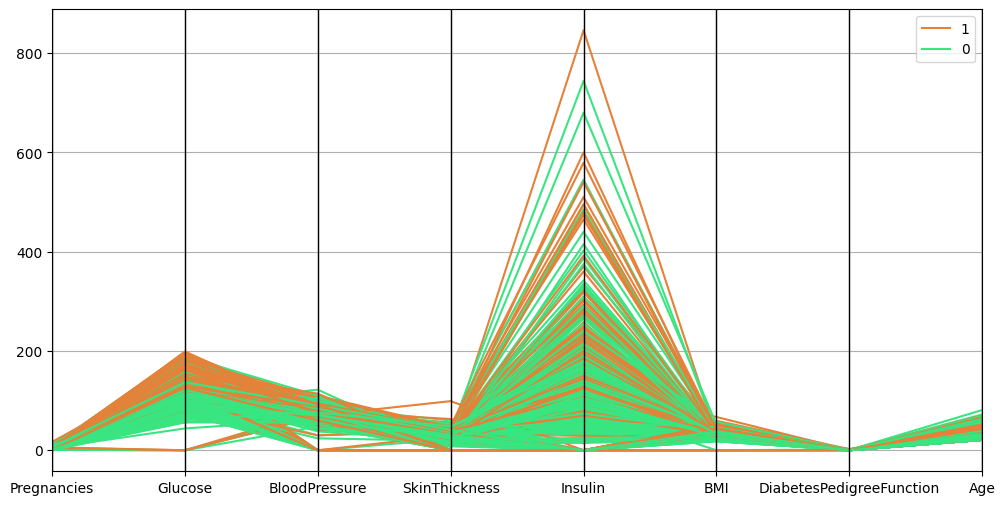

In [506]:
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(total_data, "Outcome", color = ("#E58139", "#39E581", "#8139E5"))
plt.show()

**Paso 2: Inicialización y entrenamiento del modelo**

In [507]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

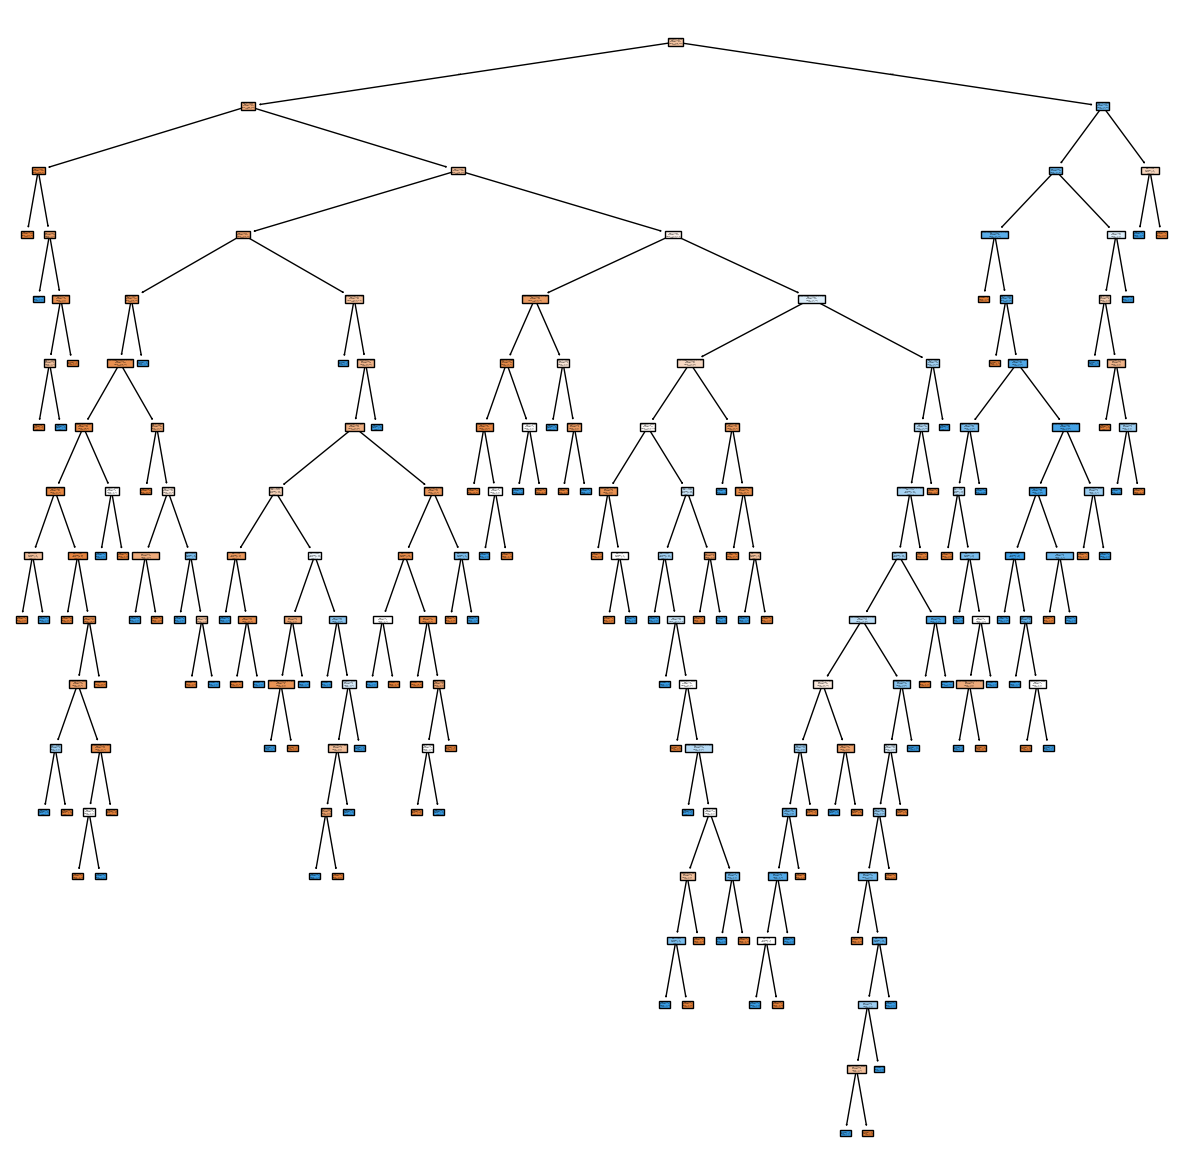

In [508]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1","2"], filled = True)

plt.show()

In [509]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])

**Paso 3: Predicción del modelo**

In [510]:
accuracy=accuracy_score(y_test, y_pred)
print( f"La precisión es de {accuracy}")

La precisión es de 0.7207792207792207


In [511]:
dump(model, open("decision_tree_classifier_default_42.sav", "wb"))

### Model optimization

In [512]:
hyperparams = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 10)

In [513]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [514]:
model = DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_leaf = 1, min_samples_split = 5, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_opt=accuracy_score(y_test, y_pred)
print( f"La precisión es de {accuracy_opt}")

La precisión es de 0.7597402597402597


In [515]:
print(f"Accuracy: {accuracy}")
print(f"Accuracy optimizado: {accuracy_opt}")


Accuracy: 0.7207792207792207
Accuracy optimizado: 0.7597402597402597


In [516]:
dump(model, open("/workspaces/machine-learning-python-template5-JohnnyXavierReyesBorbor/models/tree_classifier_crit-gini_maxdepth-5_minleaf-4_minsplit5_42.sav", "wb"))

He encontrado otro accuracy mejor. No entiendo la razón

In [517]:
model = DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_leaf = 1, min_samples_split = 2, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy2=accuracy_score(y_test, y_pred)
print( f"La precisión es de {accuracy2}")

La precisión es de 0.7662337662337663
